In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import SimpleITK as sitk
from ipywidgets import interact, fixed
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
def start_plot():
    global metric_values, multires_iterations
    metric_values = []
    multires_iterations = []
# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

In [3]:
fanimal = 'DK52'
manimal = 'DK39'
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'
MOVING = os.path.join(DIR, manimal, 'preps', 'CH1', 'thumbnail_aligned')
FIXED = os.path.join(DIR, fanimal, 'preps', 'CH1', 'thumbnail_aligned')

In [4]:
fixed_files = []
files = sorted(os.listdir(FIXED))
for file in tqdm(files):
    tif = os.path.join(FIXED, file)
    fixed_files.append(tif)
moving_files = []
files = sorted(os.listdir(MOVING))
for file in tqdm(files):
    tif = os.path.join(MOVING, file)
    moving_files.append(tif)

100%|██████████| 469/469 [00:00<00:00, 147427.76it/s]


In [5]:
start, finish = (150,200)
sorted_moving_files = sorted(moving_files[start:finish])
sorted_fixed_files = sorted(fixed_files[start:finish])

In [6]:
moving_images = sitk.ReadImage(sorted_moving_files, sitk.sitkUInt16)
fixed_images =  sitk.ReadImage(sorted_fixed_files, sitk.sitkUInt16)

In [7]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_images,
    moving_images,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY)

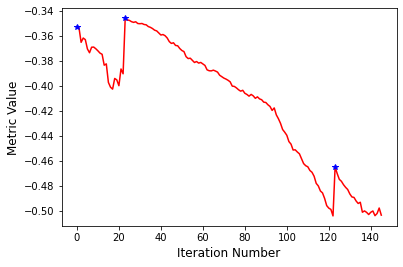

CPU times: user 2min 42s, sys: 4.78 s, total: 2min 47s
Wall time: 1min 12s


In [8]:
%%time
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                  numberOfIterations=100, 
                                                  convergenceMinimumValue=1e-6, 
                                                  convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_images, sitk.sitkFloat32), 
                                               sitk.Cast(moving_images, sitk.sitkFloat32))

In [9]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.4947021165170867
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 23.


In [10]:
moving_resampled = sitk.Resample(moving_images, 
                                 fixed_images, final_transform, sitk.sitkLinear, 0.0, moving_images.GetPixelID())


In [11]:
interact(display_images_with_alpha, 
         image_z=(0,fixed_images.GetSize()[2] - 1), 
         alpha=(0,1,0.05), 
         fixed = fixed(fixed_images), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=24, description='image_z', max=49), FloatSlider(value=0.0, description='…